# Iterative Prisoner's Dilemma


### Description

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

The strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, her on history of moves, on the number of moves played till that moment and so on, but it can only be based on a probability density function. Possible strategies are:

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

Many more and much more complex strategies can be implemented. The strategy can even change during the IPD.


### Assignments

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations. 
* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme
* Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
* (*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools


In [2]:
from abc import ABC, abstractmethod

class Player(ABC):
    """Abstract class, declare the move method"""
    @abstractmethod
    def move(self):
        pass

In [3]:
class NiceGuy(Player):
    """
    Player that always outputs the cooperate move
    """
    def __init__(self, r_history=[], move_history=[]):
        self.r_history = r_history
        self.move_history = move_history
        self.label = "NiceGuy"
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        uc = [1,0]
        self.move_history.append(uc)
        return uc
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []

    
class BadGuy(Player):
    """
    Player that always outputs the defect move
    """
    def __init__(self, r_history=[], move_history=[]):
        self.r_history = r_history
        self.move_history = move_history
        self.label = "BadGuy"
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        ud = [0,1]
        self.move_history.append(ud)
        return ud
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []

    
class KBadGuy(Player):
    """
    Player that outputs the defect move 
    with probability k/100
    """
    def __init__(self, k, r_history=[], move_history=[]):
        self.k = k
        self.r_history = r_history
        self.move_history = move_history
        self.label = str(k) + "BadGuy"
        
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def move(self):
        uc = [1,0]
        ud = [0,1]
        if np.random.rand() > 1-(self.k/100):
            u = ud
        else:
            u = uc        
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []
 
    
class Tit4Tat(Player):
    """
    Player, the first move is cooperate, 
    the subsequent moves are the same as the last 
    element in self.input_history
    """
    def __init__(self, r_history=[], move_history=[], input_history=[]):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history

    def append_reward(self, reward):
        self.r_history.append(reward)

    def append_input(self, inp):
        self.input_history.append(inp)

    def move(self):
        if len(self.input_history) == 0:
            u = [1,0]
        else:
            u = self.input_history[-1]
        self.move_history.append(u)
        return u
    
class Tit4TatMP(Player):
    """
    Player that starts with cooperate and then cooperates only if a fraction of players
    above or equal c_treshold has cooperated.
    """
    def __init__(self, r_history=[], move_history=[], input_history=[], c_threshold=0.5):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history
        self.c_threshold = c_threshold
        self.label = str(c_threshold) + "Tit4TatMP"
    
    def append_reward(self, reward):
        self.r_history.append(reward)
        
    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change. 
        """
        self.input_history.append(m_inp)
        
    def move(self):
        if len(self.input_history) == 0:
            u = [1,0]
        else:
            last_inp = np.array(self.input_history[-1])[:,0]
            if np.sum(last_inp)/np.shape(last_inp)[0] >= self.c_threshold:
                u = [1,0]
            else:
                u = [0,1]
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []
        self.input_history = []
        
        
class GrimTriggerMP(Player):
    """
    Player that cooperates until a numbers of players >= d_threshold defect in a turn,
    from now on he defects in every turn. 
    Setting d_threshold=0 means that it needs only one defecting player
    to start defecting itself.
    """
    def __init__(self, r_history=[], move_history=[], input_history=[], d_threshold=0.5):
        self.r_history = r_history
        self.move_history = move_history 
        self.input_history = input_history
        self.d_threshold = d_threshold
        self.defected = False
        self.label = "GrimTriggerMP"
    
    def append_reward(self, reward):
        self.r_history.append(reward)  
        
    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change. 
        """
        self.input_history.append(m_inp)
    
    def move(self):  
        if not self.defected and len(self.input_history) > 0:
            # check if it has been defected in the last turn
            last_inp = last_inp = np.array(self.input_history[-1])[:,0]
            if np.sum(last_inp)/np.shape(last_inp)[0] < 1 - self.d_threshold:
                self.defected = True
#                 print("debug DEFECTED")
                
        if not self.defected:
            u = [1,0]
        else:
            u = [0,1]
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []
        self.input_history = []

    
    
class LookBackPlayer(Player):
    """
    Player that use past rewards in order to decide the next move.
    """
    def __init__(self, bias, r_history=[], move_history=[], delta = 1):
        """
        bias is added to the past rewards during the move decision
        if bias is in range [-3,0] it can change the behaviour of the player
        """
        self.r_history = r_history
        self.move_history = move_history 
        self.bias = bias
        self.delta = delta
        self.label = str(delta) + "LookBackPlayer"
    
    def append_reward(self, reward):
        self.r_history.append(reward)
    

    def move(self):       
        # random move if its the first move
        if len(self.r_history) == 0:
            if np.random.rand() >= 0.5:
                u = [1,0]
            else:
                u = [0,1]
        else:            
            move_cat_history = np.array(self.move_history)
            deltas = np.array([self.delta**i for i in range(len(move_cat_history))])
            deltas = np.hstack((deltas,deltas))
            r_cat_history = np.concatenate((np.array([self.r_history]).T,np.array([self.r_history]).T), axis=1)
            sum_cat_r = np.sum((r_cat_history + self.bias) * move_cat_history, axis=0)

            if sum_cat_r[0]>sum_cat_r[1]:
                # cooperate 
                u = [1,0]
            elif sum_cat_r[0]<sum_cat_r[1]:
                # defect 
                u = [0,1]
            else:
                # random choice if parity
                if np.random.rand() >= 0.5:
                    u = [1,0]
                else:
                    u = [0,1]
                
        self.move_history.append(u)
        return u
    
    def p_reset(self):
        self.r_history = []
        self.move_history = []

## Examples of players classes

In [4]:
nice_guy = NiceGuy()

for i in range(10):
    u = nice_guy.move()
print(u)

print(nice_guy.move_history)
print(nice_guy.r_history)


[1, 0]
[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
[]


In [5]:
pino = KBadGuy(30)
for i in range(10):
    u = pino.move()
print(u)
print(pino.move_history)

[1, 0]
[[0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0]]


In [6]:

t4t_guy = Tit4Tat()
u = t4t_guy.move()
print("first move ",u)

print(t4t_guy.move_history)
t4t_guy.input_history.append([0,1])
u = t4t_guy.move()
print("second move (mirrored) ", u)

first move  [1, 0]
[[1, 0]]
second move (mirrored)  [0, 1]


In [7]:
t4t_m = Tit4TatMP([],[],[],0.5)

u = t4t_m.move()
print("first move ", u)

m_inp = [[1,0], [0,1], [0,1]]

t4t_m.append_input(m_inp)

u = t4t_m.move()
print("second move ", u)

m_inp = [[1], [0], [0], [1], [1]]
t4t_m.append_input(m_inp)

u = t4t_m.move()
print("third move ", u)

first move  [1, 0]
second move  [0, 1]
third move  [1, 0]


In [8]:
# with d_threshold=0 it needs one defecting player to change
grim_trigger = GrimTriggerMP([],[],[],0)
u = grim_trigger.move()
print("first move is cooperate ", u)

# one defector over 4 other players
m_inp = [[1,0], [1,0], [1,0], [0,1]]
grim_trigger.append_input(m_inp)

u = grim_trigger.move()
print("second move ", u)

m_inp = [[1], [1], [1], [1]]
grim_trigger.append_input(m_inp)

u = grim_trigger.move()
print("third move ", u)

u = grim_trigger.move()
print("fourth move ", u)

first move is cooperate  [1, 0]
second move  [0, 1]
third move  [0, 1]
fourth move  [0, 1]


# Part 1: 2 players IPD
Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations.

## KBadGuy vs Tit4Tat

player1 final reward  82
player2 final reward  85


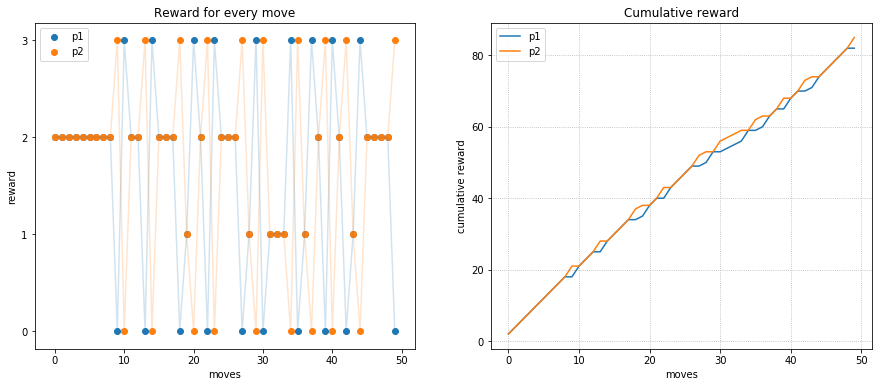

In [47]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

# for practicity we are using u as horizontal arrays
# initialize players instances
p1 = Tit4Tat([],[],[])
p2 = KBadGuy(40,[],[])

# game loop
for i in range(50):
    u1 = p1.move()
    u2 = p2.move()
    #append p2 move, necessary for the tit4tat
    p1.append_input(u2)
    
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)

# visualization
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=("p1"),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=("p2"),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("moves")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=("p1"))
ax[1].plot(np.cumsum(p2.r_history), label=("p2"))
ax[1].legend()
ax[1].set_xlabel("moves")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")


print("player1 final reward ", sum(p1.r_history))
print("player2 final reward ", sum(p2.r_history))

## Tit4Tat vs Tit4Tat

player1 final reward  200
player2 final reward  200
As expected two Tit4Tat players cooperates and obtain reward 2*i


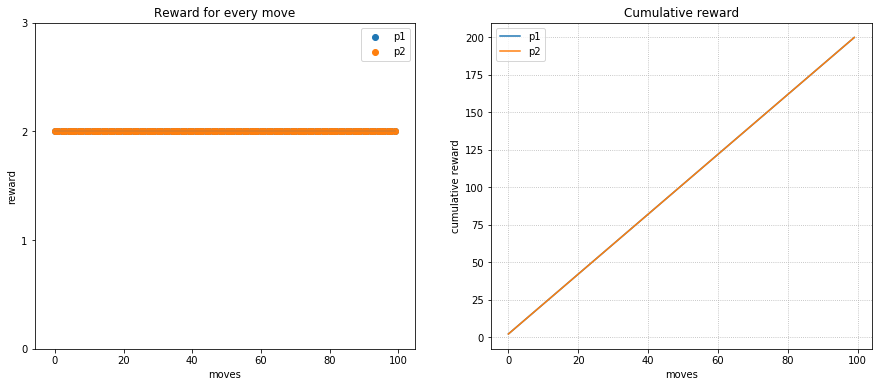

In [49]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

# for practicity we are using u as horizontal arrays
# initialize players instances
p1 = Tit4Tat([],[],[])
p2 = Tit4Tat([],[],[])

# game loop
for i in range(100):
    u1 = p1.move()
    p2.append_input(u1)
    
    u2 = p2.move()
    p1.append_input(u2)
        
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)
    
# visualization    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=("p1"),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=("p2"),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("moves")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=("p1"))
ax[1].plot(np.cumsum(p2.r_history), label=("p2"))
ax[1].legend()
ax[1].set_xlabel("moves")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")


print("player1 final reward ", sum(p1.r_history))
print("player2 final reward ", sum(p2.r_history))

print("As expected two Tit4Tat players cooperates and obtain reward 2*i")

## KBadGuy vs KBadGuy

player1 final reward  76
player2 final reward  106
If two KBadGuy are playing, the one with bigger k tends to win


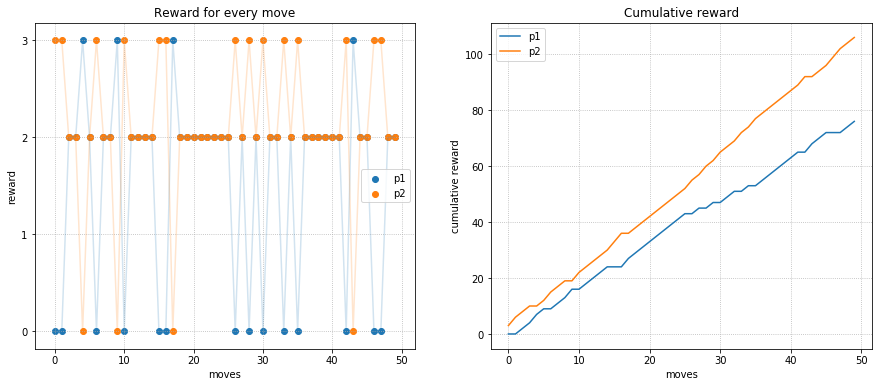

In [45]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

# initialize players instances
p1 = KBadGuy(10,[],[])
p2 = KBadGuy(30,[],[])

# game loop
for i in range(50):
    u1 = p1.move()
#     p2.append_input(u1)
    
    u2 = p2.move()
#     p1.append_input(u2)
        
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)
    
# visualization
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=("p1"),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=("p2"),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("moves")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=("p1"))
ax[1].plot(np.cumsum(p2.r_history), label=("p2"))
ax[1].legend()
ax[1].set_xlabel("moves")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")


print("player1 final reward ", sum(p1.r_history))
print("player2 final reward ", sum(p2.r_history))

print("If two KBadGuy are playing, the one with bigger k tends to win")

## Explore the entire range of KBadGuys

Analize the connection between the two *k* values and the total reward value
running multiple games with different *k*

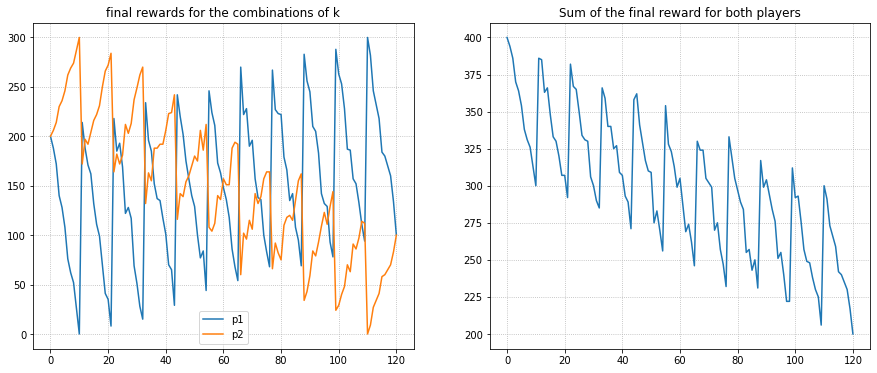

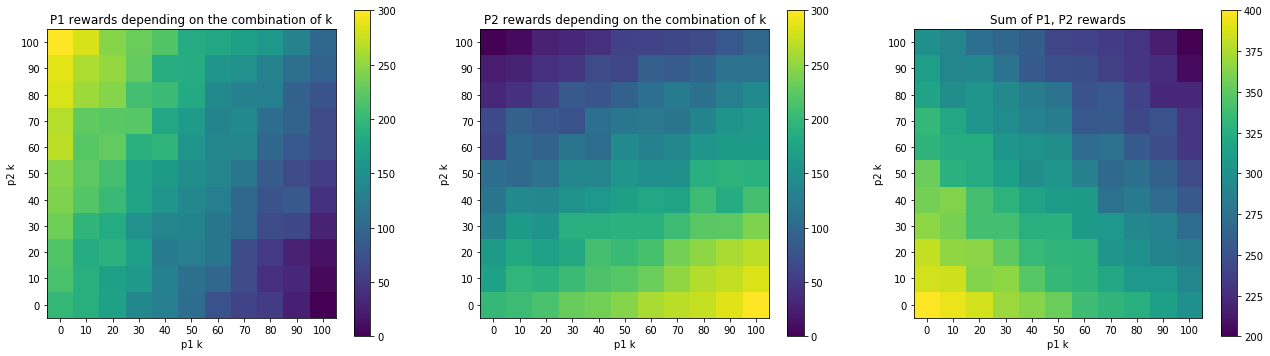

In [12]:

# Payoff matrix
M = np.array([[2,0],[3,1]])

k_p1 = np.arange(0, 101, 10)
k_schedule = np.zeros((121,2))

for i in range(0,121,11):
    k_schedule[i:i+11, 0] = k_p1[i//11]
    k_schedule[i:i+11, 1] = k_p1[:]


reward_history = []
for n in range(np.shape(k_schedule)[0]):
    reward_game = [0,0]
    p1 = KBadGuy(k_schedule[n,0],[],[])
    p2 = KBadGuy(k_schedule[n,1],[],[])
    for i in range(100):              
        u1 = p1.move()
        u2 = p2.move()

        reward1 = np.array(u1) @ M @ np.array(u2).T
        reward2 = np.array(u2) @ M @ np.array(u1).T
        p1.append_reward(reward1)
        p2.append_reward(reward2)
        
        reward_game[0] += reward1
        reward_game[1] += reward2
        
    reward_history.append(reward_game)
    
reward_history = np.asarray(reward_history)
reward_2d = np.reshape(reward_history, (11,11,2))

# visualization    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(reward_history[:,0], label=("p1"))
ax[0].plot(reward_history[:,1], label=("p2"))
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_title("final rewards for the combinations of k")
ax[1].plot(np.sum(reward_history,1), label=("p1"))
ax[1].grid(linestyle=":")
ax[1].set_title("Sum of the final reward for both players")


fig, ax = plt.subplots(1,3, figsize = (22,6))
im0 = ax[0].imshow(reward_2d[:,:,0], origin='lower')
ax[0].set_xticks(range(11))
ax[0].set_yticks(range(11))
ax[0].set_xticklabels(range(0,110,10))
ax[0].set_yticklabels(range(0,110,10))
ax[0].set_xlabel("p1 k")
ax[0].set_ylabel("p2 k")
ax[0].set_title("P1 rewards depending on the combination of k")
plt.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(reward_2d[:,:,1], origin='lower')
ax[1].set_xticks(range(11))
ax[1].set_yticks(range(11))
ax[1].set_xticklabels(range(0,110,10))
ax[1].set_yticklabels(range(0,110,10))
ax[1].set_xlabel("p1 k")
ax[1].set_ylabel("p2 k")
ax[1].set_title("P2 rewards depending on the combination of k")
plt.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(np.sum(reward_2d, 2), origin='lower')
ax[2].set_xticks(range(11))
ax[2].set_yticks(range(11))
ax[2].set_xticklabels(range(0,110,10))
ax[2].set_yticklabels(range(0,110,10))
ax[2].set_xlabel("p1 k")
ax[2].set_ylabel("p2 k")
ax[2].set_title("Sum of P1, P2 rewards")
plt.colorbar(im2, ax=ax[2])

## Introducing the LookBack Player

Experiment with LookBack players

KBadGuy final reward  47
LookBackPlayer final reward  224


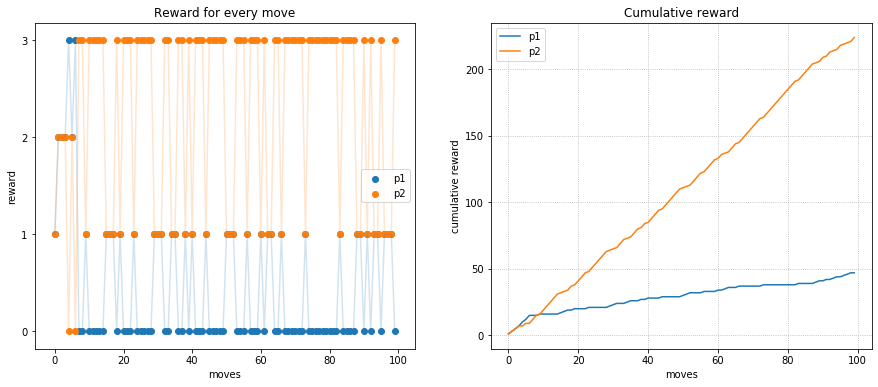

In [51]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

p1 = KBadGuy(30,[],[])
p2 = LookBackPlayer(-1.5,[],[])

for i in range(100):
    u1 = p1.move()
    u2 = p2.move()
    
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)
    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=("p1"),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=("p2"),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("moves")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=("p1"))
ax[1].plot(np.cumsum(p2.r_history), label=("p2"))
ax[1].legend()
ax[1].set_xlabel("moves")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")

print("KBadGuy final reward ", sum(p1.r_history))
print("LookBackPlayer final reward ", sum(p2.r_history))

### LookBack Player vs LookBack Player

LookBackPlayer1 final reward  192
LookBackPlayer2 final reward  192


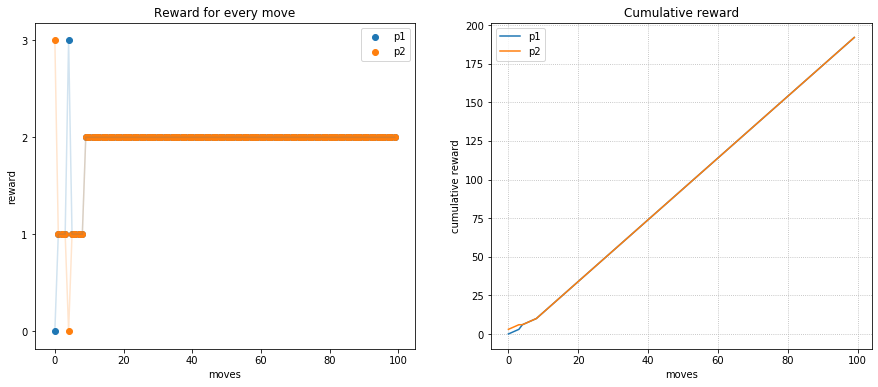

In [52]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

p1 = LookBackPlayer(-1.5,[],[])
p2 = LookBackPlayer(-1.5,[],[])

for i in range(100):
    u1 = p1.move()
    u2 = p2.move()
    
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)

    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=("p1"),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=("p2"),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("moves")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=("p1"))
ax[1].plot(np.cumsum(p2.r_history), label=("p2"))
ax[1].legend()
ax[1].set_xlabel("moves")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")

print("LookBackPlayer1 final reward ", sum(p1.r_history))
print("LookBackPlayer2 final reward ", sum(p2.r_history))

### LookBack player against every k bad player

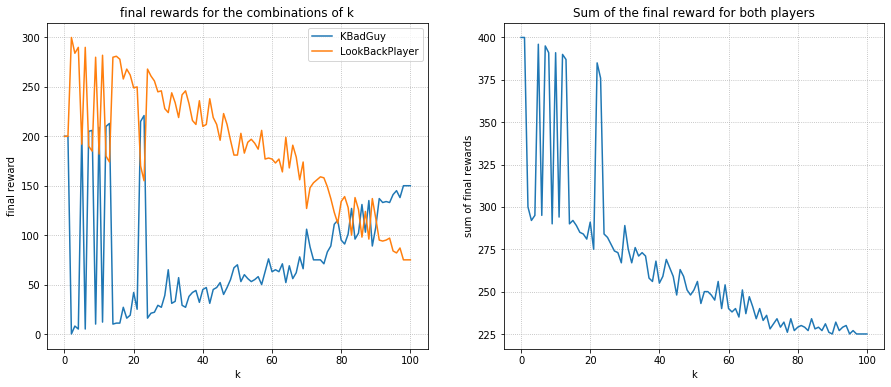

In [21]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

k_p1 = np.arange(0, 101, 10)
k_schedule = np.arange(101)
# k_schedule = np.flip(k_schedule)

reward_history = []
for n in range(np.shape(k_schedule)[0]):
    reward_game = [0,0]
    p1 = KBadGuy(k_schedule[n],[],[])
    p2 = LookBackPlayer(-1.5,[],[])
   
    for i in range(100):          
        u1 = p1.move()
        u2 = p2.move()

        reward1 = np.array(u1) @ M @ np.array(u2).T
        reward2 = np.array(u2) @ M @ np.array(u1).T
        p1.append_reward(reward1)
        p2.append_reward(reward2)
        
        reward_game[0] += reward1
        reward_game[1] += reward2
        
    reward_history.append(reward_game)
    
reward_history = np.asarray(reward_history)
# reward_2d = np.reshape(reward_history, (10,10,2))

# print(reward_history)
# visualization    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(reward_history[:,0], label=("KBadGuy"))
ax[0].plot(reward_history[:,1], label=("LookBackPlayer"))
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_title("final rewards for the combinations of k")
ax[0].set_xlabel("k")
ax[0].set_ylabel('final reward')

ax[1].plot(np.sum(reward_history,1), label=("p1"))
ax[1].grid(linestyle=":")
ax[1].set_title("Sum of the final reward for both players")
ax[1].set_xlabel("k")
ax[1].set_ylabel('sum of final rewards')

plt.show()

### LookBack player against every k bad player 
multiple run in order to reduce the randomness effects

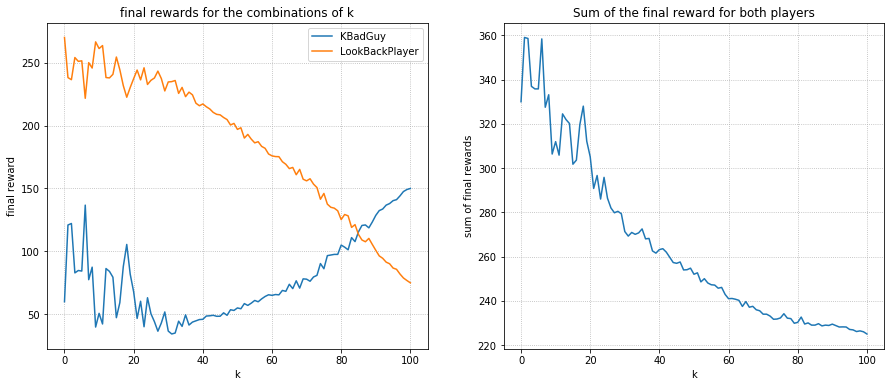

In [58]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

k_p1 = np.arange(0, 101, 10)
k_schedule = np.arange(101)


reward_history = []
games_per_batch = 20
for n in range(np.shape(k_schedule)[0]):
    reward_game_batch = [0,0]
    for j in range(games_per_batch):
        reward_game = [0,0]
        p1 = KBadGuy(k_schedule[n],[],[])
#         p2 = LookBackPlayer([],[])
        p2 = LookBackPlayer(-1.5,[],[])
        for i in range(100):      
            u1 = p1.move()
            u2 = p2.move()

            reward1 = np.array(u1) @ M @ np.array(u2).T
            reward2 = np.array(u2) @ M @ np.array(u1).T
            p1.append_reward(reward1)
            p2.append_reward(reward2)

            reward_game[0] += reward1
            reward_game[1] += reward2
            
        reward_game_batch[0] += reward_game[0]
        reward_game_batch[1] += reward_game[1]

    reward_history.append(reward_game_batch)

reward_history = np.asarray(reward_history)/games_per_batch



# visualization    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(reward_history[:,0], label=("KBadGuy"))
ax[0].plot(reward_history[:,1], label=("LookBackPlayer"))
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_title("final rewards for the combinations of k")
ax[0].set_xlabel("k")
ax[0].set_ylabel('final reward')

ax[1].plot(np.sum(reward_history,1), label=("p1"))
ax[1].grid(linestyle=":")
ax[1].set_title("Sum of the final reward for both players")
ax[1].set_xlabel("k")
ax[1].set_ylabel('sum of final rewards')

plt.show()

# Part 2: multiplayer IPD
Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme

# Part 3: reapeted multiplayer IPD with population increasing
Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration

# Part4: rMPIPD with mutating strategies
(*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined. 